In [1]:
import os
import glob
import rasterio as rio
from rasterio.mask import raster_geometry_mask
from rasterio import plot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import copy
import seaborn as sns

In [2]:
home= '/Users/kathleenkanaley/Documents/grapes_in_space/'

In [3]:
# Test adding smr band with 2020 skysat

orig_imgs = glob.glob(home +'images_work/images_analysis_ready/*/SkySat/2020*.tif')

In [4]:
def smr_weights(image, em_file) :
    '''Calculates the spectral mixture residual (smr) weights for each pixel
    in an image based on input endmember file.
    
    image: (string) path to raster 
    em_file: (string) path to .csv with reflectance values for each endmember'''
       
    # ATTENTION, MAKE SURE ENDMEMBER FILE IS ACCESSIBLE
    
    endmembers = endmember_file
    
    with rio.open(image) as src:
        raster_arr = np.array(src.read())
        raster_arr = raster_arr/10000 #scale reflectance values 

    w = 1 # sum constraint weight
    D = raster_arr # numpy-nD array
    d = np.reshape(D, [D.shape[0], D.shape[1]*D.shape[2]]) # dimensions
    G = pd.read_csv(endmembers, sep='[,|\t]', header = None).to_numpy()
    
    wavelength = G[:,0]
    G = G[:, 1:G.shape[1]].astype(np.float64)

    d_constraint = np.array(w*np.ones(d.shape[1]))
    G_constraint = np.array(w*np.ones(G.shape[1]))

    d = np.vstack([d, d_constraint])
    G = np.vstack([G, G_constraint])

    mixtureResidual_alt = d-(G.dot(np.linalg.inv(G.transpose().dot(G)).dot(G.transpose()))).dot(d)
    mixtureResidual_alt_reShp = np.reshape(mixtureResidual_alt,[d.shape[0],D.shape[1],D.shape[2]])
    
    M = np.linalg.inv(G.transpose().dot(G)).dot(G.transpose().dot(d))
    M_reShp = np.reshape(M,[M.shape[0], D.shape[1], D.shape[2]])
    
    w1 = M_reShp[0]
    w2 = M_reShp[1]
    
    em_ratio = np.divide(w1,\
                         w1+w2,\
                         out=np.zeros_like(w1),\
                         where=(w1+w2)!=0)
    
    return em_ratio

In [5]:
endmember_file = '/Users/kathleenkanaley/Downloads/endmembers_msi_noSwir.csv'
img_test = orig_imgs[0]

In [6]:
smr_imgs = [smr_weights(img, endmember_file) for img in orig_imgs]

/var/folders/hg/02pmwyy14wvgdv7n1gzwlx1w0000gn/T/ipykernel_4541/732398203.py:19: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  G = pd.read_csv(endmembers, sep='[,|\t]', header = None).to_numpy()
/var/folders/hg/02pmwyy14wvgdv7n1gzwlx1w0000gn/T/ipykernel_4541/732398203.py:19: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  G = pd.read_csv(endmembers, sep='[,|\t]', header = None).to_numpy()
/var/folders/hg/02pmwyy14wvgdv7n1gzwlx1w0000gn/T/ipykernel_4541/732398203.py:19: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and differ

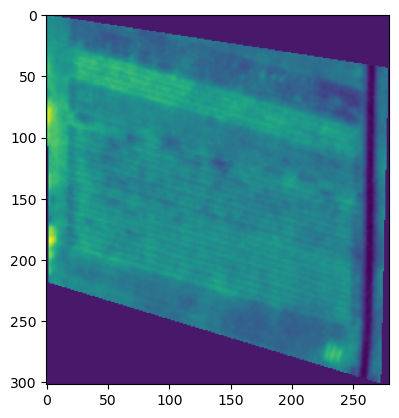

In [7]:
plt.imshow(smr_imgs[0])

In [9]:
null_img = copy.copy(smr_imgs[0])
null_img

array([[0.06175993, 0.06175993, 0.06175993, ..., 0.06175993, 0.06175993,
        0.06175993],
       [0.06175993, 0.48871723, 0.47940176, ..., 0.06175993, 0.06175993,
        0.06175993],
       [0.06175993, 0.48079381, 0.47697236, ..., 0.06175993, 0.06175993,
        0.06175993],
       ...,
       [0.06175993, 0.06175993, 0.06175993, ..., 0.06175993, 0.06175993,
        0.06175993],
       [0.06175993, 0.06175993, 0.06175993, ..., 0.06175993, 0.06175993,
        0.06175993],
       [0.06175993, 0.06175993, 0.06175993, ..., 0.06175993, 0.06175993,
        0.06175993]])

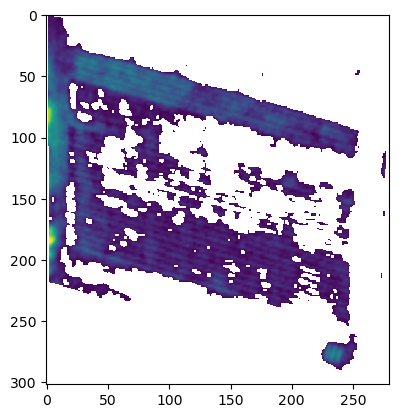

In [10]:
# try nulling all pixels with smr weights < 0.4

null_img[null_img<0.45]=np.nan

plt.imshow(null_img)

In [11]:
#Create a mask of pixels with smr < 0.5
import numpy.ma as ma

#first copy the image (as an array)
# so we can further select a subset (need to use copy because arrays are mutable/changeable)

with rio.open(orig_imgs[0]) as src:
        raster_arr = np.array(src.read())
        raster_arr = raster_arr/10000
        #D = np.reshape(raster_arr, [raster_arr.shape[0], raster_arr.shape[1]*raster_arr.shape[2]]) # dimensions
        
comp_img = copy.copy(raster_arr)


bandcount = range(comp_img.shape[0])

for b in bandcount:
    band = comp_img[b]
    band[smr_imgs[0]<0.45]=np.nan

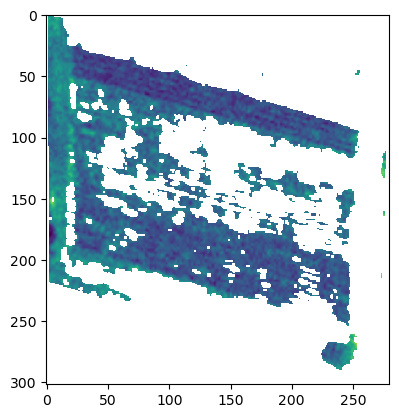

In [12]:
plt.imshow(comp_img[0])

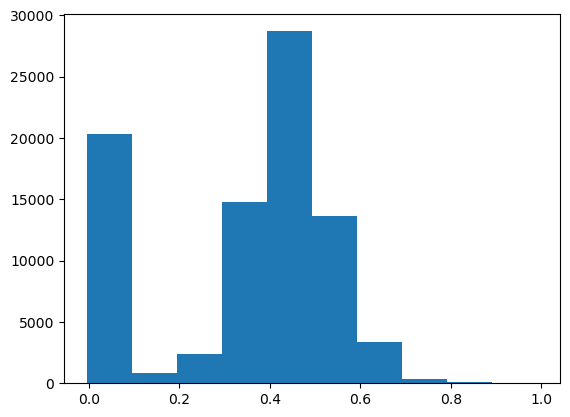

In [13]:
plt.hist(smr_imgs[0].flatten())
plt.show()

In [14]:
# Modify function to stack smr + original img bands in a single array

def smr_weights(image, em_file) :
    '''Calculates the spectral mixture residual (smr) weights for each pixel
    in an image based on input endmember file.
    
    image: (string) path to raster 
    em_file: (string) path to .csv with reflectance values for each endmember
    
    returns: array with original image bands + endmembers'''
       

    # ATTENTION, MAKE SURE ENDMEMBER FILE IS ACCESSIBLE
    
    endmembers = endmember_file
    
    with rio.open(image) as src:
        raster_arr = np.array(src.read())
        raster_arr = raster_arr/10000 #scale reflectance values
   

    w = 1 # sum constraint weight
    D = raster_arr # numpy-nD array
    d = np.reshape(D, [D.shape[0], D.shape[1]*D.shape[2]]) # dimensions
    G = pd.read_csv(endmembers, sep='[,|\t]', header = None).to_numpy()
    
    wavelength = G[:,0]
    G = G[:, 1:G.shape[1]].astype(np.float64)

    d_constraint = np.array(w*np.ones(d.shape[1]))
    G_constraint = np.array(w*np.ones(G.shape[1]))

    d = np.vstack([d, d_constraint])
    G = np.vstack([G, G_constraint])

    mixtureResidual_alt = d-(G.dot(np.linalg.inv(G.transpose().dot(G)).dot(G.transpose()))).dot(d)
    mixtureResidual_alt_reShp = np.reshape(mixtureResidual_alt,[d.shape[0],D.shape[1],D.shape[2]])
    
    M = np.linalg.inv(G.transpose().dot(G)).dot(G.transpose().dot(d))
    M_reShp = np.reshape(M,[M.shape[0], D.shape[1], D.shape[2]])
    
    w1 = M_reShp[0]
    w2 = M_reShp[1]
    
    em_ratio = np.divide(w1,\
                         w1+w2,\
                         out=np.zeros_like(w1),\
                         where=(w1+w2)!=0)
    
    #Reshape em_ratio to enable stacking with original 3D img array
    
    em_ratio_rs = em_ratio.reshape(1,em_ratio.shape[0],em_ratio.shape[1])
    
    stacked_raster = np.vstack([raster_arr, em_ratio_rs])
    
    return stacked_raster

In [15]:
new_smr_imgs = [smr_weights(img, endmember_file) for img in orig_imgs]


/var/folders/hg/02pmwyy14wvgdv7n1gzwlx1w0000gn/T/ipykernel_4541/1397883909.py:25: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  G = pd.read_csv(endmembers, sep='[,|\t]', header = None).to_numpy()
/var/folders/hg/02pmwyy14wvgdv7n1gzwlx1w0000gn/T/ipykernel_4541/1397883909.py:25: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  G = pd.read_csv(endmembers, sep='[,|\t]', header = None).to_numpy()
/var/folders/hg/02pmwyy14wvgdv7n1gzwlx1w0000gn/T/ipykernel_4541/1397883909.py:25: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and dif

In [16]:
new_smr_imgs[0].shape

(5, 302, 280)

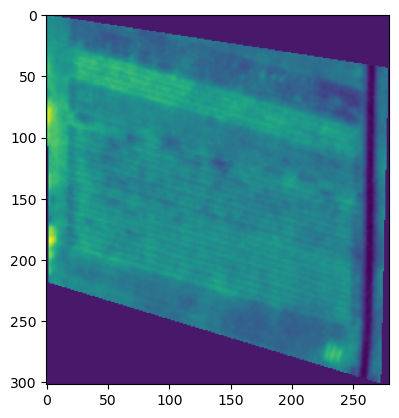

In [17]:
# Visualize smr band
plt.imshow(new_smr_imgs[0][4])

In [18]:
# Function to mask the new image by smr band

def smr_mask(arr, thresh, smr_band):
    import copy
    masked_arr = copy.copy(arr)
    
    bandcount = range(masked_arr.shape[0])
    
    for b in bandcount:
        band = masked_arr[b]
        band[arr[smr_band]<thresh]=np.nan #https://www.neonscience.org/resources/learning-hub/tutorials/mask-raster-py
        
    return masked_arr

In [19]:
mask_test = smr_mask(new_smr_imgs[0], 0.45, 4)

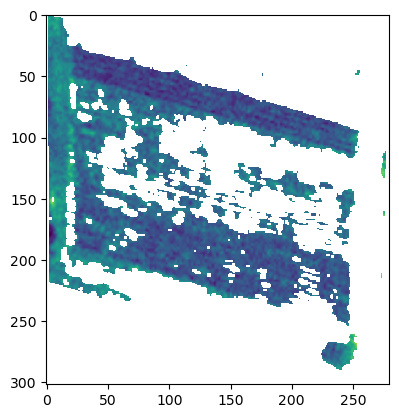

In [20]:
plt.imshow(mask_test[0])

In [21]:
# Next: array to raster

def smr_weights_raster(image, em_file) :
    '''Calculates the spectral mixture residual (smr) weights for each pixel
    in an image based on input endmember file.
    
    image: (string) path to raster 
    em_file: (string) path to .csv with reflectance values for each endmember
    
    returns: array with original image bands + endmembers'''
       

    # ATTENTION, MAKE SURE ENDMEMBER FILE IS ACCESSIBLE
    
    endmembers = endmember_file
    
    with rio.open(image) as src:
        raster_arr = np.array(src.read())
        raster_arr = raster_arr/10000 #scale reflectance values
   

    w = 1 # sum constraint weight
    D = raster_arr # numpy-nD array
    d = np.reshape(D, [D.shape[0], D.shape[1]*D.shape[2]]) # dimensions
    G = pd.read_csv(endmembers, sep='[,|\t]', header = None).to_numpy()
    
    wavelength = G[:,0]
    G = G[:, 1:G.shape[1]].astype(np.float64)

    d_constraint = np.array(w*np.ones(d.shape[1]))
    G_constraint = np.array(w*np.ones(G.shape[1]))

    d = np.vstack([d, d_constraint])
    G = np.vstack([G, G_constraint])

    mixtureResidual_alt = d-(G.dot(np.linalg.inv(G.transpose().dot(G)).dot(G.transpose()))).dot(d)
    mixtureResidual_alt_reShp = np.reshape(mixtureResidual_alt,[d.shape[0],D.shape[1],D.shape[2]])
    
    M = np.linalg.inv(G.transpose().dot(G)).dot(G.transpose().dot(d))
    M_reShp = np.reshape(M,[M.shape[0], D.shape[1], D.shape[2]])
    
    w1 = M_reShp[0]
    w2 = M_reShp[1]
    
    em_ratio = np.divide(w1,\
                         w1+w2,\
                         out=np.zeros_like(w1),\
                         where=(w1+w2)!=0)
    
    #Reshape em_ratio to enable stacking with original 3D img array
    
    em_ratio_rs = em_ratio.reshape(1,em_ratio.shape[0],em_ratio.shape[1])
    
    stacked_arr = np.vstack([raster_arr, em_ratio_rs])
    
    # Save stacked array as raster
    with rio.open(image) as src:
        kwargs = src.meta
        band_ct = stacked_arr.shape[0]
        kwargs.update(dtype=rio.float32, count=band_ct)
        
        with rio.open(str(os.path.split(image)[0])+'/SMR_'+str(os.path.basename(image)), 'w', **kwargs) as dst:
            for b in range(stacked_arr.shape[0]):
                dst.write_band(b+1, stacked_arr[b].astype(rio.float32))

In [22]:
smr_weights_raster(orig_imgs[0],endmember_file)

/var/folders/hg/02pmwyy14wvgdv7n1gzwlx1w0000gn/T/ipykernel_4541/1280978006.py:25: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  G = pd.read_csv(endmembers, sep='[,|\t]', header = None).to_numpy()


In [23]:
# smr weights + mask

def smr_mask(arr, thresh, smr_band):
    import copy
    masked_arr = copy.copy(arr)
    
    bandcount = range(masked_arr.shape[0])
    
    for b in bandcount:
        band = masked_arr[b]
        band[arr[smr_band]<thresh]=np.nan #https://www.neonscience.org/resources/learning-hub/tutorials/mask-raster-py
        
    return masked_arr

def smr_weights_masked(image, em_file, thresh) :
    '''Calculates the spectral mixture residual (smr) weights for each pixel
    in an image based on input endmember file.
    
    image: (string) path to raster 
    em_file: (string) path to .csv with reflectance values for each endmember
    thresh: threshold value of smr weight to use for mask
    
    returns: raster with original image bands + smr weight band, masked according to smr threshold'''
       

    # ATTENTION, MAKE SURE ENDMEMBER FILE IS ACCESSIBLE
    
    endmembers = endmember_file
    
    with rio.open(image) as src:
        raster_arr = np.array(src.read())
        raster_arr = raster_arr/10000 #scale reflectance values
   

    w = 1 # sum constraint weight
    D = raster_arr # numpy-nD array
    d = np.reshape(D, [D.shape[0], D.shape[1]*D.shape[2]]) # dimensions
    G = pd.read_csv(endmembers, sep='[,|\t]', header = None).to_numpy()
    
    wavelength = G[:,0]
    G = G[:, 1:G.shape[1]].astype(np.float64)

    d_constraint = np.array(w*np.ones(d.shape[1]))
    G_constraint = np.array(w*np.ones(G.shape[1]))

    d = np.vstack([d, d_constraint])
    G = np.vstack([G, G_constraint])

    mixtureResidual_alt = d-(G.dot(np.linalg.inv(G.transpose().dot(G)).dot(G.transpose()))).dot(d)
    mixtureResidual_alt_reShp = np.reshape(mixtureResidual_alt,[d.shape[0],D.shape[1],D.shape[2]])
    
    M = np.linalg.inv(G.transpose().dot(G)).dot(G.transpose().dot(d))
    M_reShp = np.reshape(M,[M.shape[0], D.shape[1], D.shape[2]])
    
    w1 = M_reShp[0]
    w2 = M_reShp[1]
    
    em_ratio = np.divide(w1,\
                         w1+w2,\
                         out=np.zeros_like(w1),\
                         where=(w1+w2)!=0)
    
    #Reshape em_ratio to enable stacking with original 3D img array
    
    em_ratio_rs = em_ratio.reshape(1,em_ratio.shape[0],em_ratio.shape[1])
    
    stacked_arr = np.vstack([raster_arr, em_ratio_rs])
    
    masked_arr = smr_mask(stacked_arr, thresh, stacked_arr.shape[0]-1) #last band = smr band
    
    # Save stacked array as raster
    with rio.open(image) as src:
        kwargs = src.meta
        band_ct = masked_arr.shape[0]
        kwargs.update(dtype=rio.float32, count=band_ct)
        
        with rio.open(str(os.path.split(image)[0])+'/SMRmasked_'+str(os.path.basename(image)), 'w', **kwargs) as dst:
            for b in range(masked_arr.shape[0]):
                dst.write_band(b+1, masked_arr[b].astype(rio.float32))

# Use SMR veg. weight to calculate MSAVI2 

Goal: Use the value of the smr veg. weight for each pixel to infer "L" in the MSAVI2 calculation.

L varies inversely with vegetation cover, so higher veg. weight should yield lower L.

L = 1-veg. weight

1. Add veg. weight band to image using smr function
2. Use the veg. weight to approximate L
3. Use L to calculate experimental MSAVI2 at each pixel
4. Add experimental MSAVI2 array as band to raster
5. Add "conventional" MSAVI2 as band to raster
4. Look at it

SAVI formula:

((NIR - R) / (NIR + R + L)) * (1 + L)

MSAVI2 formula (no prior knowledge of L):

(2 * NIR + 1 – sqrt ((2 * NIR + 1)2 – 8 * (NIR - R))) / 2

In [112]:
# Use veg. weight to calculate MSAVI

def smr_to_msavi(image, veg_band, red, nir) :
    '''Calculates the modified soil-adjusted vegetation index (MSAVI) for each pixel 
    in an image based on the per pixel fractional veg. cover.
    
    image: (string) path to raster 
    veg_band (int): veg fraction band number
    red (int): red band band number
    nir (int): nir band band number
    
    returns: raster with original image bands + veg fraction band + MSAVI band'''
    
    with rio.open(image) as src:
        raster_arr = np.array(src.read())
        raster_arr = raster_arr#/10000 #scale reflectance values
    
    # Matrix of ones, same size as veg. wt. band
    L_ones = np.ones(raster_arr[0].shape) 
    
    # Calculate L
    # (subtract 1 from all band nummbers because arrays are 0 indexed)
    L = L_ones - raster_arr[veg_band-1] 
    
    red_band = raster_arr[red-1]
    
    nir_band = raster_arr[nir-1]
    
    # Experimental MSAVI
    msavi_exp = ((nir_band - red_band) / (nir_band + red_band + L)) * (1 + L)
    
    # Conventional MSAVI
    msavi_conv = (2*(nir_band) + 1 - np.sqrt((2*(nir_band) + 1)*2 - 8*(nir_band - red_band)))/2
    
    #Reshape MSAVI arrays to enable stacking with original 3D img array
    msavi_exp_rs = msavi_exp.reshape(1,msavi_exp.shape[0],msavi_exp.shape[1])
    
    msavi_conv_rs = msavi_conv.reshape(1,msavi_conv.shape[0],msavi_conv.shape[1])
    
    stacked_arr = np.vstack([raster_arr, msavi_exp_rs, msavi_conv_rs])
    
    #return stacked_arr
    
    # Save stacked array as raster
    with rio.open(image) as src:
        kwargs = src.meta
        band_ct = stacked_arr.shape[0]
        kwargs.update(dtype=rio.float32, count=band_ct)
        
        with rio.open(str(os.path.split(image)[0])+'/SMR_MSAVI_'+str(os.path.basename(image)), 'w', **kwargs) as dst:
            for b in range(stacked_arr.shape[0]):
                dst.write_band(b+1, stacked_arr[b].astype(rio.float32))

In [124]:
# Test

smr_img = '/Users/kathleenkanaley/Documents/grapes_in_space/images_work/images_analysis_ready/2020/SkySat/SMR_20200710_155028_ssc3d2_0012_ar.tif'
msavi_arr = smr_to_msavi(smr_img, 5, 3, 4)

In [120]:
with rio.open('/Users/kathleenkanaley/Documents/grapes_in_space/images_work/images_analysis_ready/2020/SkySat/SMR_MSAVI_SMR_20200710_155028_ssc3d2_0012_ar.tif') as src:
    msmr_arr = src.read()

In [121]:
msmr_arr.shape

(7, 302, 280)

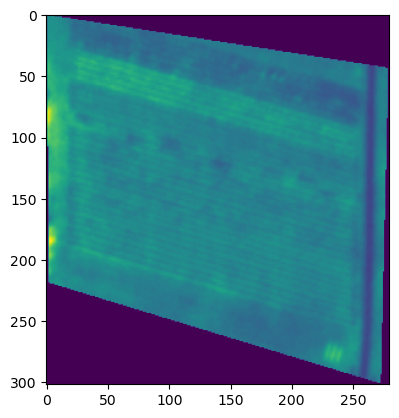

In [126]:
# MSAVI, conventional calculation
plt.imshow(msmr_arr[6])

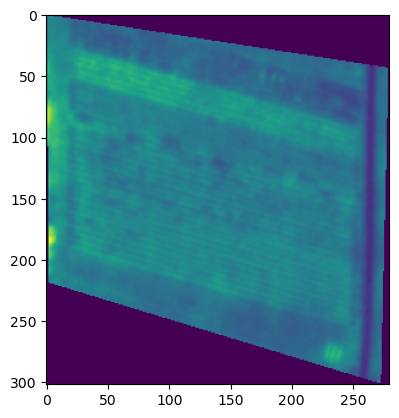

In [127]:
# MSAVI, experimental calculation
plt.imshow(msmr_arr[5])

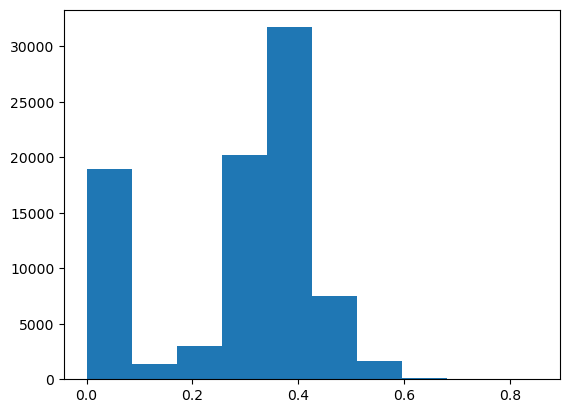

In [128]:
# distribution of experimental MSAVI values
plt.hist(msmr_arr[5].flatten())
plt.show()

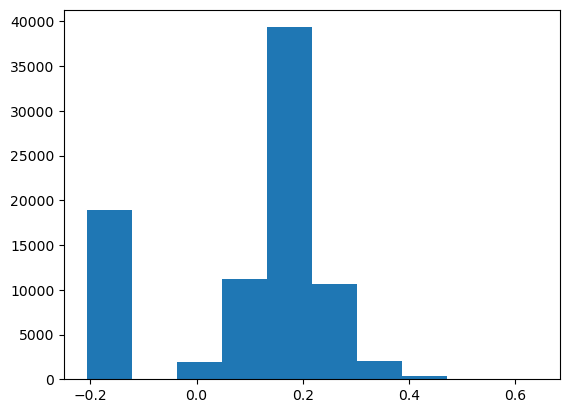

In [130]:
# Distrib. of conventional MSAVI values
plt.hist(msmr_arr[6].flatten())
plt.show()

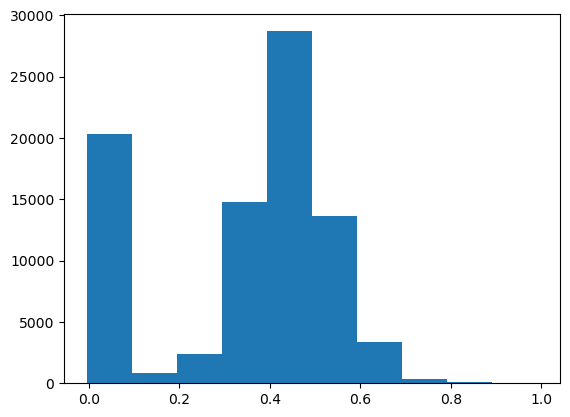

In [131]:
# Distrib of veg. weight values
plt.hist(msmr_arr[4].flatten())
plt.show()

In [132]:
# Gut check
np.array_equal(msmr_arr[4], msmr_arr[5])

False

In [133]:
L_ones = np.ones(msmr_arr[4].shape)
L_ones.shape

(302, 280)

In [139]:
(msmr_arr[4].shape[0],msmr_arr[4].shape[1]) 

(302, 280)

Text(0, 0.5, 'VegSMR')

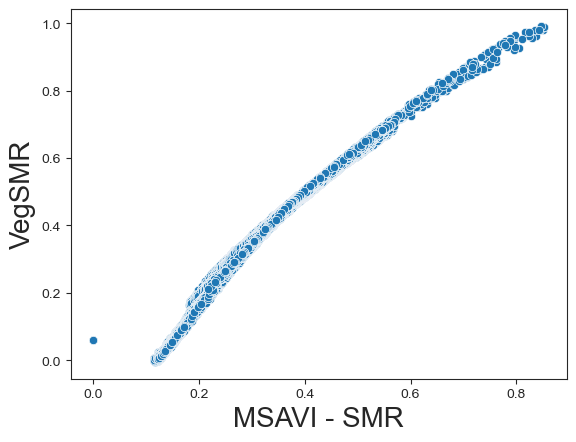

In [157]:
with rio.open('/Users/kathleenkanaley/Documents/grapes_in_space/images_work/images_analysis_ready/2020/SkySat/SMR_MSAVI_SMR_20200710_155028_ssc3d2_0012_ar.tif') as img_smr:
    #img_smr = src.read()
    smrW = img_smr.read(5).flatten()
    msavi_smr = img_smr.read(6).flatten()
    msavi = img_smr.read(7).flatten()

sns.scatterplot(x=msavi_smr, y=smrW)
plt.xlabel('MSAVI - SMR', fontsize = 20)
plt.ylabel('VegSMR', fontsize =20)

Text(0, 0.5, 'VegSMR')

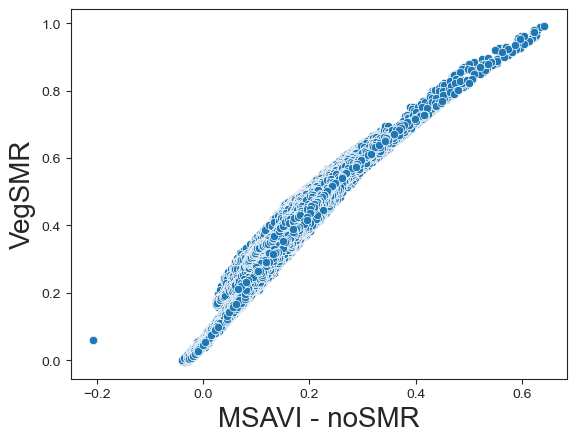

In [159]:
sns.scatterplot(x=msavi, y=smrW)
plt.xlabel('MSAVI - noSMR', fontsize = 20)
plt.ylabel('VegSMR', fontsize =20)

Text(0, 0.5, 'MSAVI + SMR')

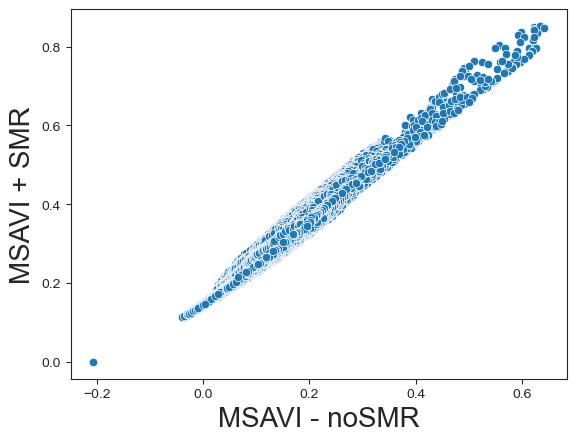

In [160]:
sns.scatterplot(x=msavi, y=msavi_smr)
plt.xlabel('MSAVI - noSMR', fontsize = 20)
plt.ylabel('MSAVI + SMR', fontsize =20)

In [167]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def scatterplot_with_color_ramp_diagonal_xy(x, y):
    """
    Create a scatter plot with a color ramp applied diagonally across the x and y axes.
    :param x: a list of x-coordinates
    :param y: a list of y-coordinates
    """
    # Define the color map
    cmap = LinearSegmentedColormap.from_list("mycmap", ["red", "yellow", "green"])

    # Create the scatter plot with the color ramp
    plt.scatter(x, y, c=x, cmap=cmap)

    # Add a color bar
    cbar = plt.colorbar()
    cbar.set_label("VegSMR")

    # Set the x and y limits to be the same
    xlim = plt.xlim()
    ylim = plt.ylim()
    lims = [min(xlim[0], ylim[0]), max(xlim[1], ylim[1])]
    plt.xlim(lims)
    plt.ylim(lims)
    plt.xlabel('VegSMR', fontsize = 20)
    plt.ylabel('MSAVI - SMR', fontsize =20)

    # Add the diagonal line
    plt.plot(lims, lims, color="black")

    # Show the plot
    plt.show()

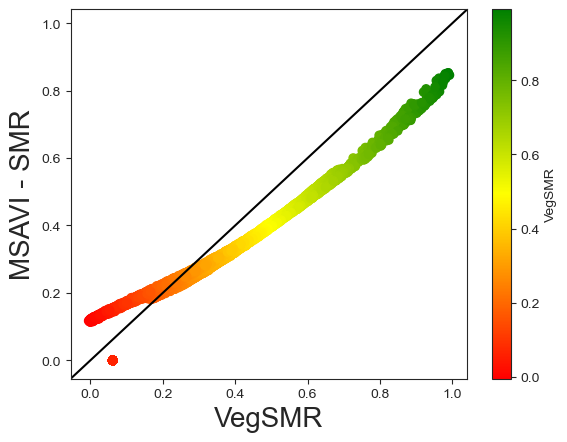

In [168]:
scatterplot_with_color_ramp_diagonal_xy(smrW, msavi_smr)